In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    horizontal_flip=True,  
    zoom_range=0.2,  
    rotation_range=20,  
    validation_split=0.2  
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_data = train_datagen.flow_from_directory(
    r'C:/Users/SUMIT MITRA/Final Year Project/cancer/train',  
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_data = test_datagen.flow_from_directory(
    r'C:/Users/SUMIT MITRA/Final Year Project/cancer/val', 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_data = test_datagen.flow_from_directory(
    r'C:/Users/SUMIT MITRA/Final Year Project/cancer/test',  
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4961 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.


In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
for layer in base_model.layers:
    layer.trainable = False
def build_model(hp):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)),
        Dense(1, activation='sigmoid')  
    ])

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  
    executions_per_trial=2,  
    directory='tuner_dir',
    project_name='blood_cancer_tuning'
)

Reloading Tuner from tuner_dir\blood_cancer_tuning\tuner0.json


In [21]:
tuner.search(train_data, epochs=10, validation_data=val_data)
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hp.values}")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
history = best_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_data=val_data,
    validation_steps=val_data.samples // BATCH_SIZE,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

C:\Users\SUMIT MITRA\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters: {'units': 256, 'dropout': 0.4, 'optimizer': 'rmsprop'}
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 740ms/step - accuracy: 0.8690 - loss: 0.3011 - val_accuracy: 0.7000 - val_loss: 0.5981
Epoch 2/20
  1/155 ━━━━━━━━━━━━━━━━━━━━ 1:56 756ms/step - accuracy: 0.9062 - loss: 0.2119

C:\Users\SUMIT MITRA\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.2119 - val_accuracy: 0.7000 - val_loss: 0.6898
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 113s 725ms/step - accuracy: 0.8786 - loss: 0.2664 - val_accuracy: 0.8000 - val_loss: 0.5399
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.2897 - val_accuracy: 0.8000 - val_loss: 0.5557
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 110s 709ms/step - accuracy: 0.8876 - loss: 0.2535 - val_accuracy: 0.8000 - val_loss: 0.5239
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.3528 - val_accuracy: 0.8000 - val_loss: 0.7427
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 110s 709ms/step - accuracy: 0.8862 - loss: 0.2663 - val_accuracy: 0.7000 - val_loss: 0.9175
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.2346 - val_accuracy: 0.7000 - val_loss: 0.5779
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 110s 712ms/step - accuracy: 0.8983 - loss: 0.2265 - val_accurac

40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 681ms/step - accuracy: 0.7798 - loss: 0.4153
Test Accuracy: 82.15%
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 686ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81       629
           1       0.78      0.89      0.83       620

    accuracy                           0.82      1249
   macro avg       0.83      0.82      0.82      1249
weighted avg       0.83      0.82      0.82      1249



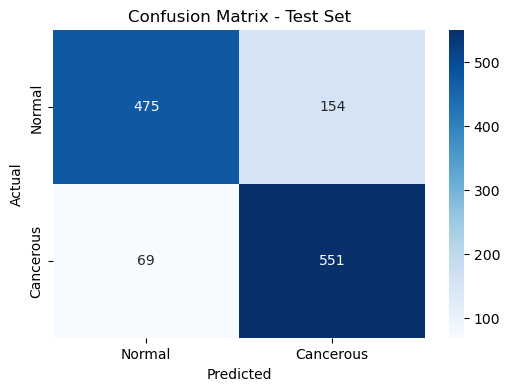

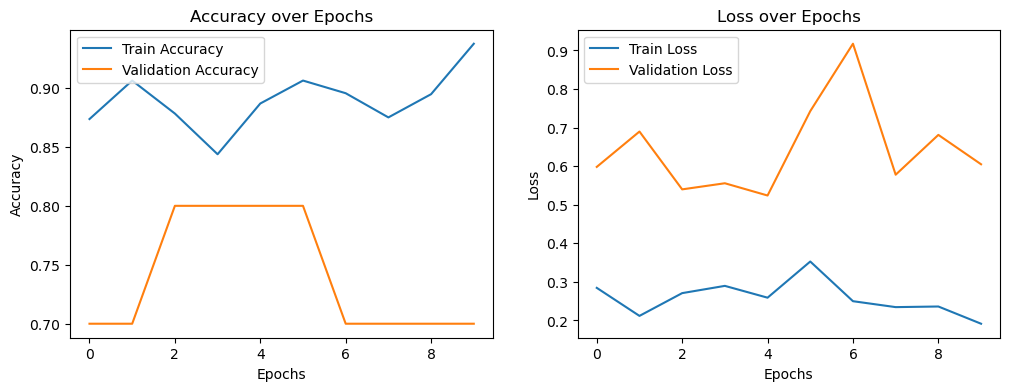

In [25]:
test_loss, test_acc = best_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
test_predictions = best_model.predict(test_data)
test_predictions = (test_predictions > 0.5).astype(int)
print("Classification Report:\n", classification_report(test_data.classes, test_predictions))

conf_matrix = confusion_matrix(test_data.classes, test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cancerous'], yticklabels=['Normal', 'Cancerous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()